<a href="https://colab.research.google.com/github/ereinha/PMAE/blob/main/UCI_Higgs_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Uncomment this cell to store files to your personal google drive
# from google.colab import drive
# drive.mount('/content/drive/MyDrive')
# %cd PMAE

In [2]:
!git clone https://github.com/ereinha/PMAE

Cloning into 'PMAE'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 284 (delta 76), reused 113 (delta 64), pack-reused 150
Receiving objects: 100% (284/284), 4.58 MiB | 12.97 MiB/s, done.
Resolving deltas: 100% (161/161), done.


In [3]:
%cd PMAE

/content/PMAE


In [4]:
!pwd

/content/PMAE


In [5]:
import train
import utils
import test_and_plot
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import json
from models import classifier, pmae
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

In [6]:
# Download the files from UCI ML repository
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
!gzip -d HIGGS.csv.gz

--2023-07-27 15:18:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz            [     <=>            ]   2.62G  18.8MB/s    in 2m 25s  

2023-07-27 15:20:50 (18.6 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858]



In [7]:
# Read in the csv
data = pd.read_csv('./HIGGS.csv', header=None)

In [8]:
# Split the data and labels
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [9]:
# Get the inputs and outputs
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [10]:
# Grab only the first 500k items
X = X[:1000000]
y = y[:1000000]

In [11]:
print(X.shape)

(1000000, 28)


In [12]:
# Remove high level features and add 0 padding to line up related quantities
X = np.delete(X, obj=np.s_[X.shape[1]-7:X.shape[1]], axis=-1)
X = np.insert(X, obj=np.s_[3:4], values=0, axis=-1)
X = np.insert(X, obj=np.s_[5:6], values=0, axis=-1)
X = np.insert(X, obj=np.s_[7:8], values=0, axis=-1)

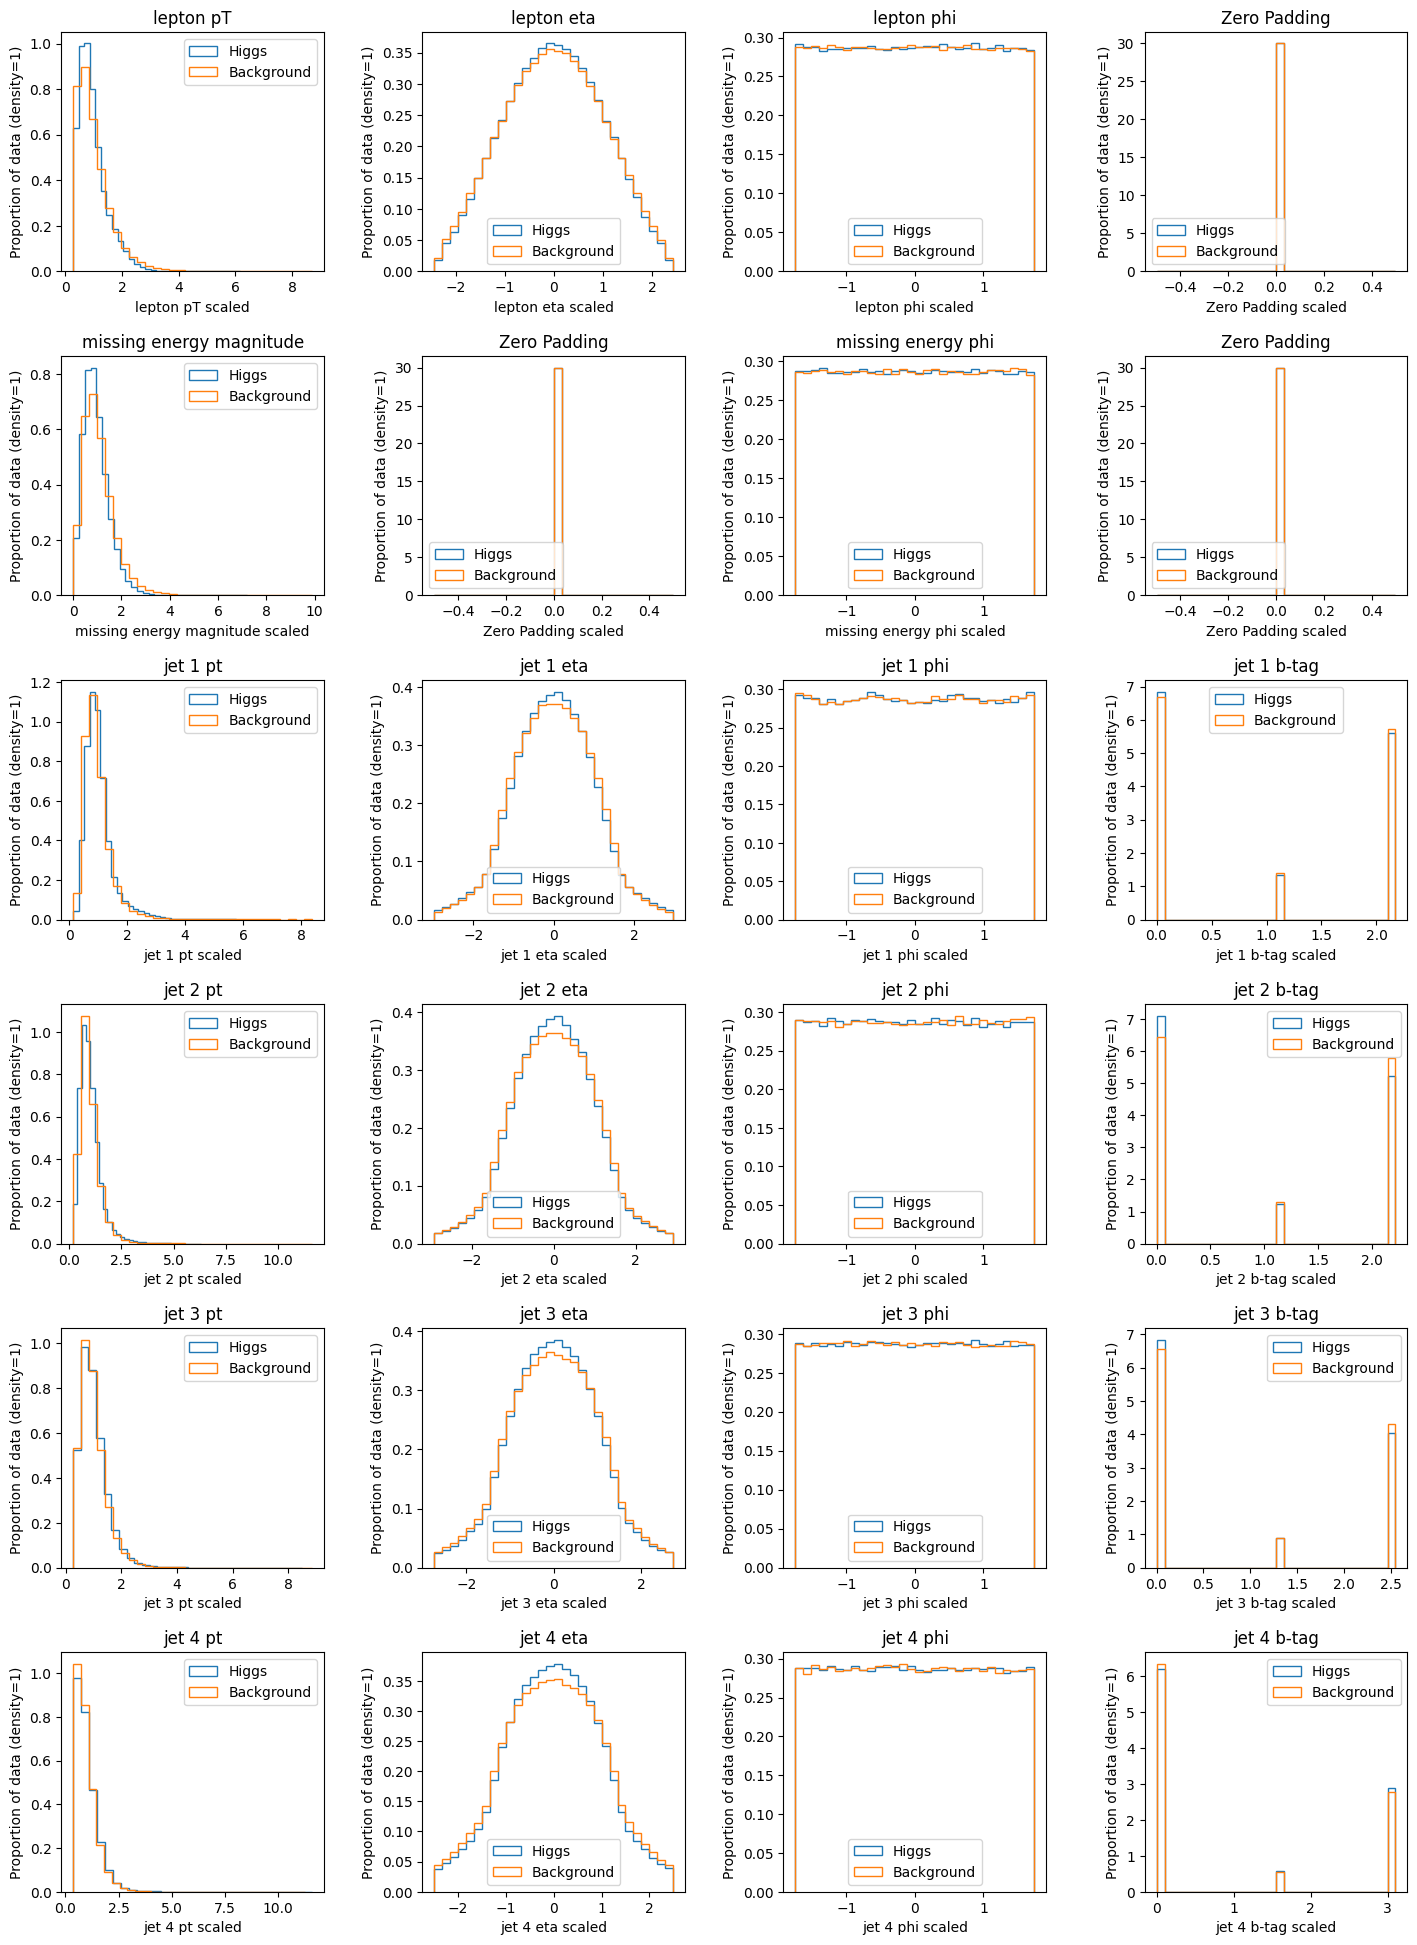

In [13]:
# Visualizing the data
names = ["lepton pT", "lepton eta", "lepton phi", "Zero Padding",
         "missing energy magnitude", "Zero Padding", "missing energy phi", "Zero Padding",
         "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag",
         "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag",
         "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag",
         "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag"]

fig, axes = plt.subplots(6,4, figsize=(15,20))
fig.tight_layout(pad=4)

X_higgs = X[y==1]
X_nohiggs = X[y==0]
y_higgs = y[y==1]
y_nohiggs = y[y==0]

for i in range(len(axes)):
    for j in range(len(axes[0])):
        axes[i,j].hist(X_higgs[:,i*4+j], histtype='step', stacked=False, density=1, bins=30, label='Higgs')
        axes[i,j].hist(X_nohiggs[:,i*4+j], histtype='step', stacked=False, density=1, bins=30, label='Background')
        axes[i,j].set_title(names[i*4+j])
        axes[i,j].set_xlabel(names[i*4+j] + ' scaled')
        axes[i,j].legend()
        axes[i,j].set_ylabel("Proportion of data (density=1)")
plt.show()

In [14]:
print(len(X_higgs))
print(len(X_nohiggs))

529673
470327


In [15]:
# Create data labels for Higgs and Non-Higgs (ttbar) data (for the UCI set we can also use the y values)
labels_hh = np.ones(len(X_higgs))
labels_tt = np.zeros(len(X_nohiggs))

In [16]:
# Split the Higgs data into train and test sets .8, .1, .1
X_hh_train, X_val1, labels_hh_train, labels_val1 = train_test_split(X_higgs, labels_hh, test_size=0.2, random_state=42)
X_hh_val, X_hh_test, labels_hh_val, labels_hh_test = train_test_split(X_val1, labels_val1, test_size=0.5, random_state=42)

In [17]:
# Normalize data relative to the Higgs train data
x_scaler = StandardScaler()
X_hh_train = x_scaler.fit_transform(X_hh_train)
X_hh_val = x_scaler.transform(X_hh_val)
X_hh_test = x_scaler.transform(X_hh_test)
X_nohiggs = x_scaler.transform(X_nohiggs)

In [18]:
# Split the ttbar data into train and test sets .8, .1, .1
X_tt_train, X_val1, labels_tt_train, labels_val1 = train_test_split(X_nohiggs, labels_tt, test_size=0.2, random_state=42)
X_tt_val, X_tt_test, labels_tt_val, labels_tt_test = train_test_split(X_val1, labels_val1, test_size=0.5, random_state=42)

In [19]:
print(np.shape(X_hh_train), np.shape(X_tt_train))

(423738, 24) (376261, 24)


In [20]:
# Reshape the data to have shape [batch_size,particles,features]
X_hh_train = X_hh_train.reshape(X_hh_train.shape[0],6,4)
X_hh_val = X_hh_val.reshape(X_hh_val.shape[0],6,4)
X_hh_test = X_hh_test.reshape(X_hh_test.shape[0],6,4)
X_tt_train = X_tt_train.reshape(X_tt_train.shape[0],6,4)
X_tt_val = X_tt_val.reshape(X_tt_val.shape[0],6,4)
X_tt_test = X_tt_test.reshape(X_tt_test.shape[0],6,4)

# Compute some quantities to be used for calculation
phi_limit = np.max((abs(np.max(X_hh_train[:,0,2])), abs(np.min(X_hh_train[:,0,2])))) # Only need one value assuming phi distrubtions are all uniform
lower_pt_limit = [np.min(X_hh_train[:,0,0]), np.min(X_hh_train[:,1,0]), np.min(X_hh_train[:,2,0]), np.min(X_hh_train[:,3,0]), np.min(X_hh_train[:,4,0]), np.min(X_hh_train[:,5,0])]

In [21]:
# Create a mixed sample of Higgs and ttbar data
X_train = np.append(X_hh_train, X_tt_train, axis=0)
X_val = np.append(X_hh_val, X_tt_val, axis=0)
X_test = np.append(X_hh_test, X_tt_test, axis=0)
labels_train = np.append(labels_hh_train, labels_tt_train, axis=0)
labels_val = np.append(labels_hh_val, labels_tt_val, axis=0)
labels_test = np.append(labels_hh_test, labels_tt_test, axis=0)

In [22]:
# Load a config file from a json
with open('./configs/uci_higgs_config_demo.json', 'r') as f:
    config = json.load(f)

In [23]:
model_name = (
    f'Model_DM{config["d_model"]}_H{config["num_heads"]}_L{config["num_layers"]}'
    f'_F{config["d_ff"]}_Dr{config["dropout"]}_B{config["batch_size"]}_T{config["test_batch_size"]}'
    f'_RE{config["resume_epoch"]}_NE{config["num_epochs"]}_ES{config["epochs_to_saturate"]}'
    f'_IM{config["init_momentum"]}_MM{config["max_momentum"]}_TILR{config["tae_init_lr"]}'
    f'_CILR{config["class_init_lr"]}_MSL{config["max_seq_len"]}_Mk{config["mask"]}'
    f'_A{config["alpha"]}_B{config["beta"]}_G{config["gamma"]}_D{config["delta"]}_OV{config["output_vars"]}'
    f'_WD{config["weight_decay"]}_MLR{config["min_lr"]}_LD{config["lr_decay"]}'
    f'_CIF{config["class_input_features"]}_CFD{config["class_ff_dim"]}'
)

In [24]:
# Set device to use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Build the autoencoder model
tae = pmae.TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'], config['max_seq_len'], config['output_vars'], config['dropout'], device)
# Build classifier
bin_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])

In [26]:
# Send the models to gpu if possible
tae = tae.to(device)
bin_class = bin_class.to(device)

In [27]:
# Assign the criterion
criterion = utils.custom_loss(phi_limit, lower_pt_limit, config['alpha'], config['beta'], config['gamma'], config['delta'], config['output_vars'])
criterion_2 = nn.BCELoss()

In [28]:
# Instantiate the dataset and DataLoader
train_data = utils.DataLabelDataset(X_train, labels_train)
train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
hh_train_data = train_data = utils.DataLabelDataset(X_hh_train, labels_hh_train)
hh_train_loader = DataLoader(hh_train_data, batch_size=config['batch_size'], shuffle=True)
val_data = utils.DataLabelDataset(X_val, labels_val)
val_loader = DataLoader(val_data, batch_size=config['test_batch_size'], shuffle=True)
hh_val_data = train_data = utils.DataLabelDataset(X_hh_val, labels_hh_val)
hh_val_loader = DataLoader(hh_val_data, batch_size=config['test_batch_size'], shuffle=True)
test_data = utils.DataLabelDataset(X_test, labels_test)
test_loader = DataLoader(test_data, batch_size=config['test_batch_size'], shuffle=False)

In [29]:
# Build the optimizers
optimizer = utils.SGDWithSaturatingMomentumAndDecay(tae.parameters(), lr=config['tae_init_lr'], momentum=config['init_momentum'], max_momentum=config['max_momentum'],
                                                    epochs_to_saturate=config['epochs_to_saturate'], batches_per_epoch=len(hh_train_loader), weight_decay=0,
                                                    lr_decay=config['lr_decay'], min_lr=config['min_lr'], resume_epoch=config['resume_epoch'])
optimizer_2 = utils.SGDWithSaturatingMomentumAndDecay(bin_class.parameters(), lr=config['class_init_lr'], momentum=config['init_momentum'],
                                                      max_momentum=config['max_momentum'],  epochs_to_saturate=config['epochs_to_saturate'],
                                                      batches_per_epoch=len(train_loader), weight_decay=config['weight_decay'], lr_decay=config['lr_decay'],
                                                      min_lr=config['min_lr'], resume_epoch=config['resume_epoch'])

In [30]:
# Train the autoencoder
val_loss_min = train.train(hh_train_loader, hh_val_loader, [tae], device, optimizer, criterion, 'autoencoder', config['output_vars'], mask=config['mask'],
                           num_epochs=config['num_epochs']-config['resume_epoch'], save_path='./saved_models/uci_higgs', model_name=model_name)

Epoch [1/50], Batch [500/828], Loss: -0.0416


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Epoch [1/50], Val Loss: -0.0963
Epoch [2/50], Batch [500/828], Loss: -0.1005
Epoch [2/50], Val Loss: -0.1215
Epoch [3/50], Batch [500/828], Loss: -0.1171
Epoch [3/50], Val Loss: -0.1253
Epoch [4/50], Batch [500/828], Loss: -0.1258
Epoch [4/50], Val Loss: -0.1333
Epoch [5/50], Batch [500/828], Loss: -0.1303
Epoch [5/50], Val Loss: -0.1373
Epoch [6/50], Batch [500/828], Loss: -0.1337
Epoch [6/50], Val Loss: -0.1390
Epoch [7/50], Batch [500/828], Loss: -0.1357
Epoch [7/50], Val Loss: -0.1388
Epoch [8/50], Batch [500/828], Loss: -0.1373
Epoch [8/50], Val Loss: -0.1447
Epoch [9/50], Batch [500/828], Loss: -0.1384
Epoch [9/50], Val Loss: -0.1436
Epoch [10/50], Batch [500/828], Loss: -0.1390
Epoch [10/50], Val Loss: -0.1445
Epoch [11/50], Batch [500/828], Loss: -0.1398
Epoch [11/50], Val Loss: -0.1458
Epoch [12/50], Batch [500/828], Loss: -0.1408
Epoch [12/50], Val Loss: -0.1442
Epoch [13/50], Batch [500/828], Loss: -0.1411
Epoch [13/50], Val Loss: -0.1451
Epoch [14/50], Batch [500/828], Loss

In [31]:
# Build the autoencoder model
tae = pmae.TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'],
                                  config['max_seq_len'], config['output_vars'], config['dropout'], device)
tae.load_state_dict(torch.load('./saved_models/uci_higgs/TAE_best_' + model_name))
tae = tae.to(device)

In [32]:
# Train a partial-event classifier
val_loss_min = train.train(train_loader, val_loader, [tae, bin_class], device, optimizer_2, criterion_2, 'classifier partial', config['output_vars'],
                           mask=config['mask'], num_epochs=config['num_epochs']-config['resume_epoch'], save_path='./saved_models/uci_higgs', model_name=model_name)

Epoch [1/50], Batch [500/1563], Loss: 0.6625
Epoch [1/50], Batch [1000/1563], Loss: 0.6408
Epoch [1/50], Batch [1500/1563], Loss: 0.6312
Epoch [1/50], Val Loss: 0.6255
Epoch [2/50], Batch [500/1563], Loss: 0.6245
Epoch [2/50], Batch [1000/1563], Loss: 0.6209
Epoch [2/50], Batch [1500/1563], Loss: 0.6175
Epoch [2/50], Val Loss: 0.6139
Epoch [3/50], Batch [500/1563], Loss: 0.6149
Epoch [3/50], Batch [1000/1563], Loss: 0.6128
Epoch [3/50], Batch [1500/1563], Loss: 0.6130
Epoch [3/50], Val Loss: 0.6105
Epoch [4/50], Batch [500/1563], Loss: 0.6083
Epoch [4/50], Batch [1000/1563], Loss: 0.6097
Epoch [4/50], Batch [1500/1563], Loss: 0.6079
Epoch [4/50], Val Loss: 0.6074
Epoch [5/50], Batch [500/1563], Loss: 0.6049
Epoch [5/50], Batch [1000/1563], Loss: 0.6045
Epoch [5/50], Batch [1500/1563], Loss: 0.6049
Epoch [5/50], Val Loss: 0.6037
Epoch [6/50], Batch [500/1563], Loss: 0.6017
Epoch [6/50], Batch [1000/1563], Loss: 0.6027
Epoch [6/50], Batch [1500/1563], Loss: 0.6026
Epoch [6/50], Val Loss:

In [33]:
# Build classifier
bin_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])
bin_class = bin_class.to(device)

In [34]:
# Refresh classifier optimizer
optimizer_2 = utils.SGDWithSaturatingMomentumAndDecay(bin_class.parameters(), lr=config['class_init_lr'], momentum=config['init_momentum'],
                                                      max_momentum=config['max_momentum'],  epochs_to_saturate=config['epochs_to_saturate'],
                                                      batches_per_epoch=len(train_loader), weight_decay=config['weight_decay'], lr_decay=config['lr_decay'],
                                                      min_lr=config['min_lr'], resume_epoch=config['resume_epoch'])

In [35]:
# Train a full event classifier
val_loss_min = train.train(train_loader, val_loader, [tae, bin_class], device, optimizer_2, criterion_2, 'classifier full', config['output_vars'],
                           mask=config['mask'], num_epochs=config['num_epochs']-config['resume_epoch'], save_path='./saved_models/uci_higgs', model_name=model_name)

Epoch [1/50], Batch [500/1563], Loss: 0.6469
Epoch [1/50], Batch [1000/1563], Loss: 0.6194
Epoch [1/50], Batch [1500/1563], Loss: 0.6109
Epoch [1/50], Val Loss: 0.6003
Epoch [2/50], Batch [500/1563], Loss: 0.5976
Epoch [2/50], Batch [1000/1563], Loss: 0.5893
Epoch [2/50], Batch [1500/1563], Loss: 0.5865
Epoch [2/50], Val Loss: 0.5832
Epoch [3/50], Batch [500/1563], Loss: 0.5759
Epoch [3/50], Batch [1000/1563], Loss: 0.5761
Epoch [3/50], Batch [1500/1563], Loss: 0.5742
Epoch [3/50], Val Loss: 0.5706
Epoch [4/50], Batch [500/1563], Loss: 0.5659
Epoch [4/50], Batch [1000/1563], Loss: 0.5673
Epoch [4/50], Batch [1500/1563], Loss: 0.5649
Epoch [4/50], Val Loss: 0.5667
Epoch [5/50], Batch [500/1563], Loss: 0.5584
Epoch [5/50], Batch [1000/1563], Loss: 0.5605
Epoch [5/50], Batch [1500/1563], Loss: 0.5579
Epoch [5/50], Val Loss: 0.5628
Epoch [6/50], Batch [500/1563], Loss: 0.5513
Epoch [6/50], Batch [1000/1563], Loss: 0.5545
Epoch [6/50], Batch [1500/1563], Loss: 0.5537
Epoch [6/50], Val Loss:

In [36]:
# Parse a json config interpretation from a model name string
config = utils.parse_model_name(model_name)

In [37]:
# Build the autoencoder model
tae = pmae.TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'],
                                  config['max_seq_len'], config['output_vars'], config['dropout'], device)
tae.load_state_dict(torch.load('./saved_models/uci_higgs/TAE_best_' + model_name))
# Build classifier
bin_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])

In [38]:
# Send the models to gpu if possible
tae = tae.to(device)
bin_class = bin_class.to(device)

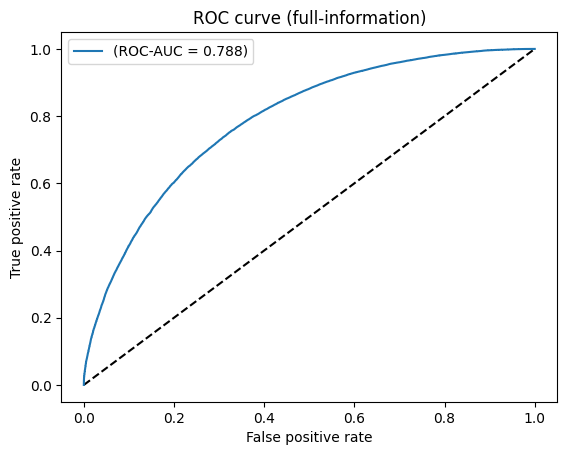

Classification Accuracy (full-information):  0.7160028399716003


<Figure size 640x480 with 0 Axes>

In [39]:
# Test the model and generate some plots
bin_class.load_state_dict(torch.load('./saved_models/uci_higgs/Classifier_full_best_' + model_name))
test_and_plot.test(test_loader, config['test_batch_size'], X_test, labels_test, names, [tae, bin_class], device,
                   config['mask'], x_scaler, config['output_vars'], 'full', model_name)

# Note: zero-padded values aren't part of the loss function in this demo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


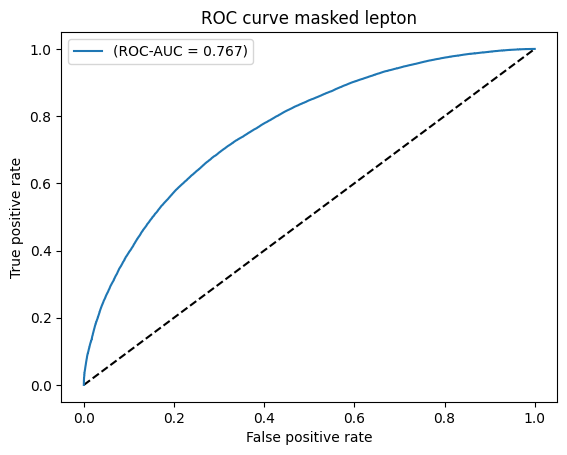

Classification Accuracy (masked  lepton ):  0.6958230417695823


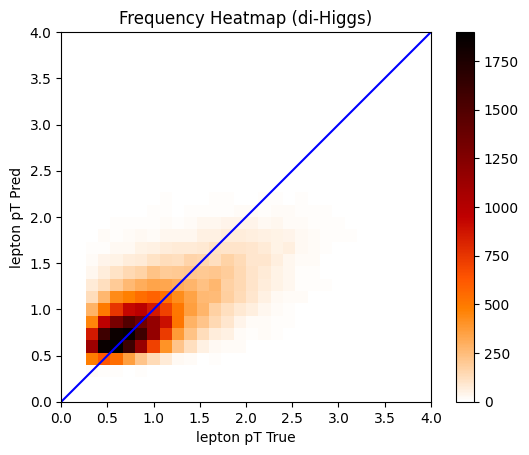

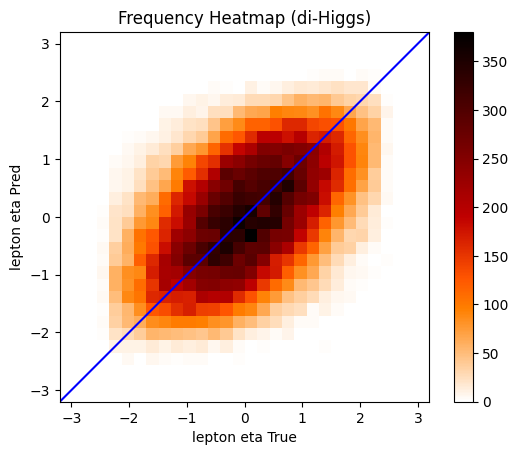

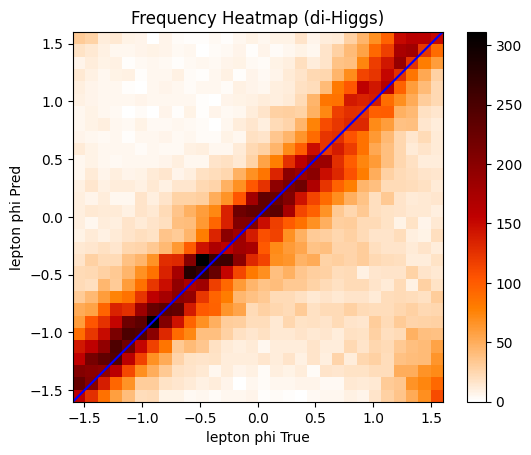

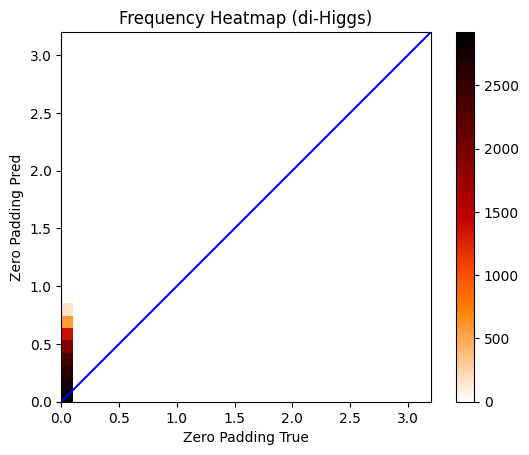

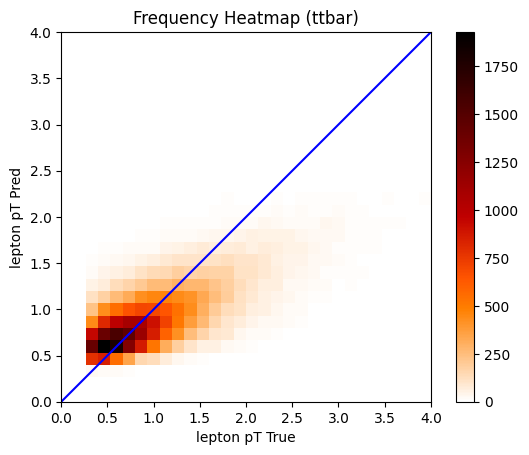

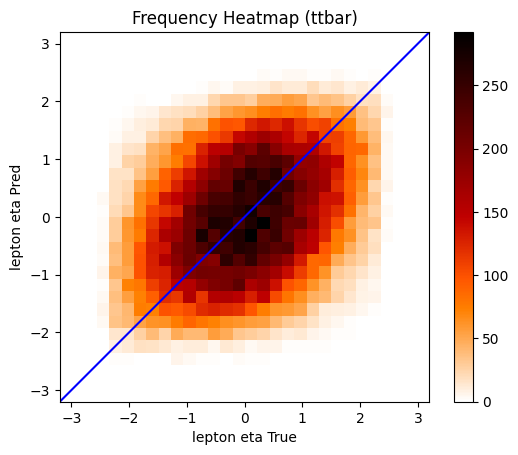

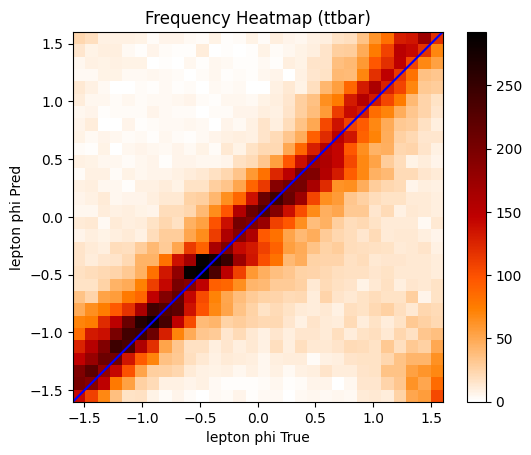

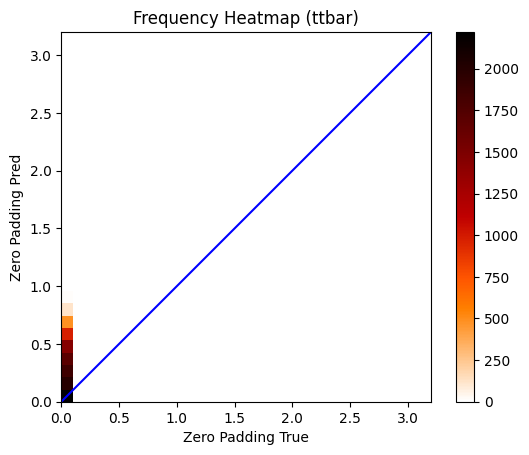

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


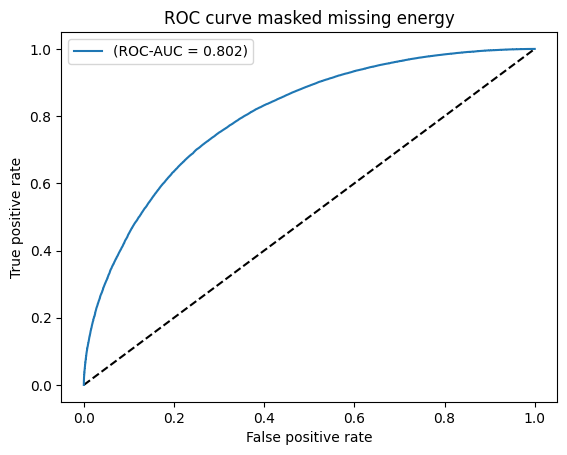

Classification Accuracy (masked  missing energy ):  0.7270327296727033


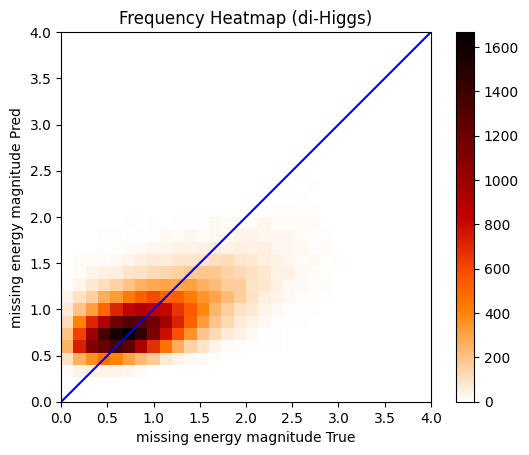

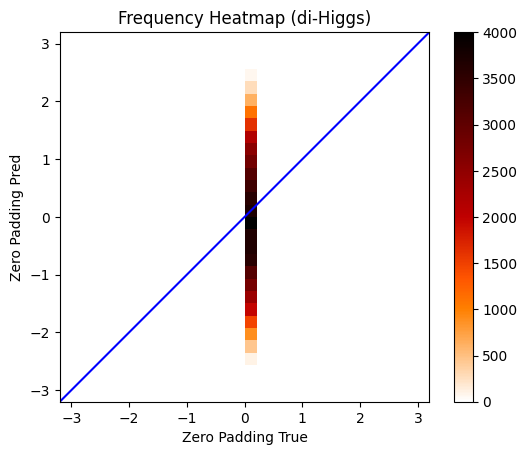

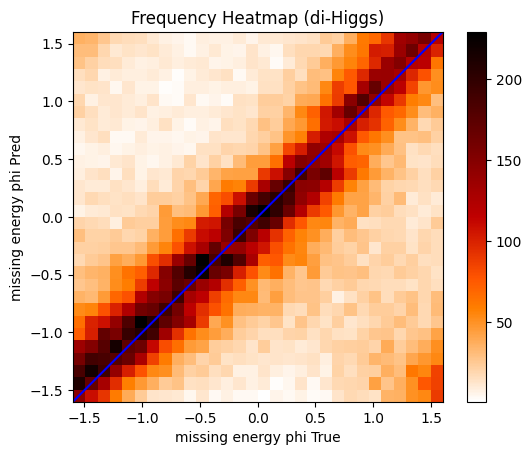

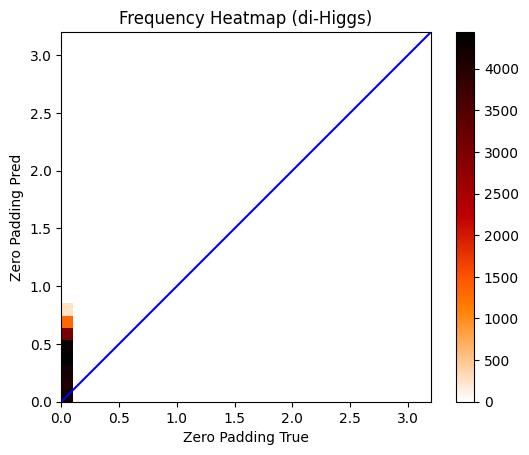

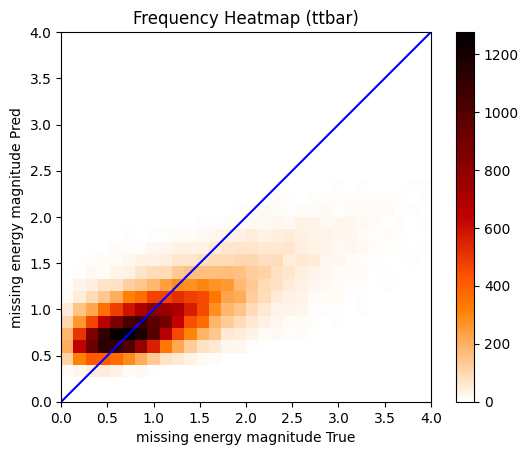

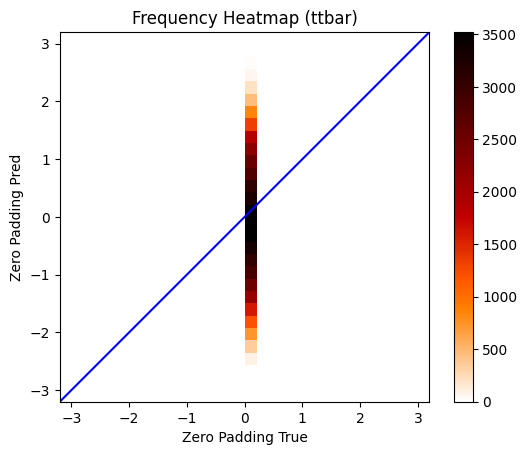

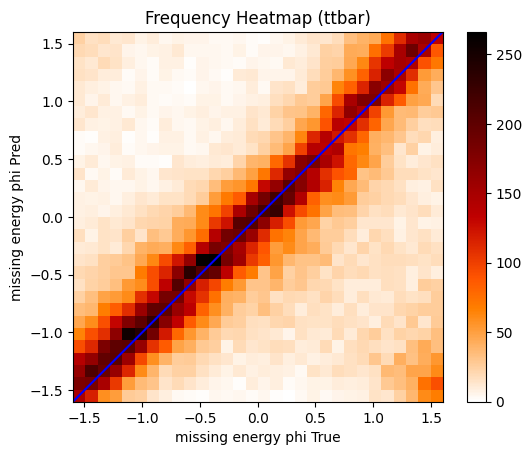

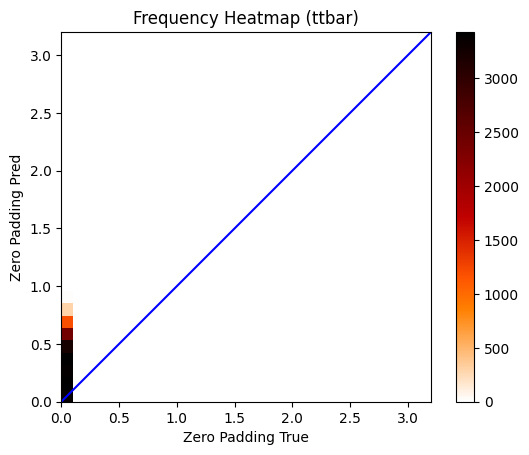

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


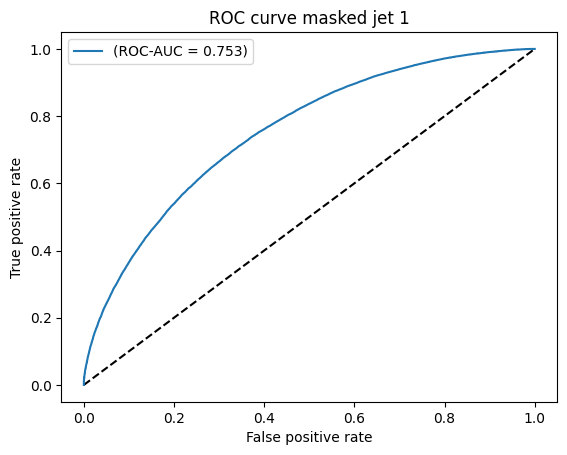

Classification Accuracy (masked  jet 1 ):  0.6852831471685283


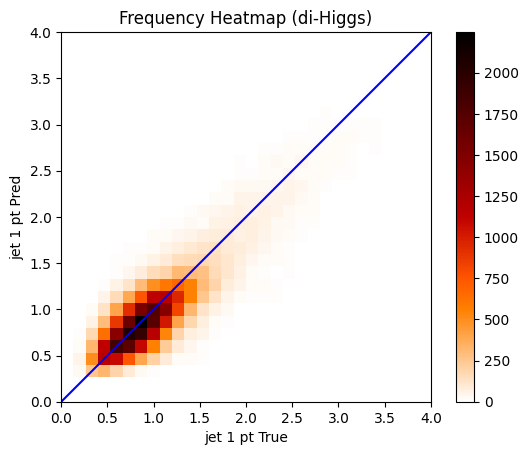

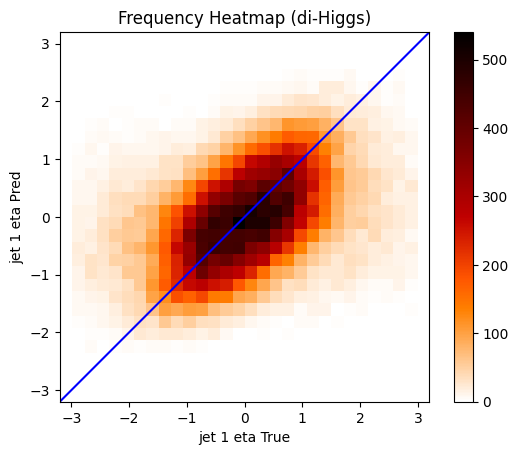

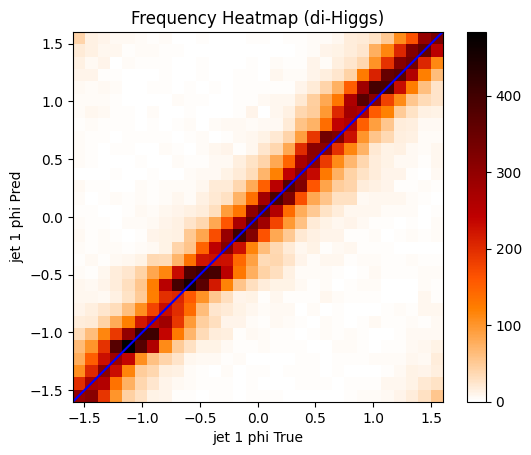

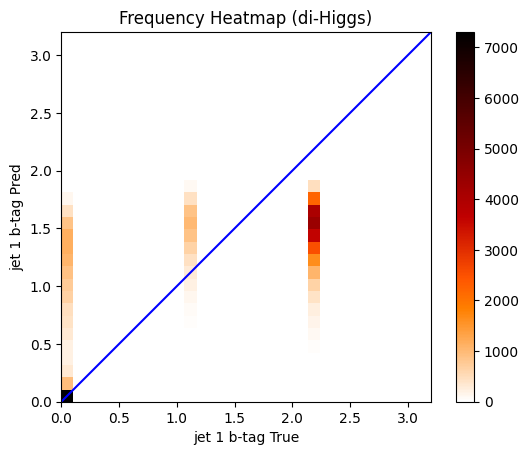

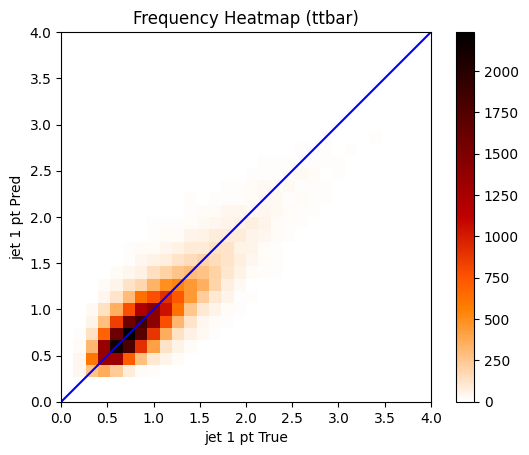

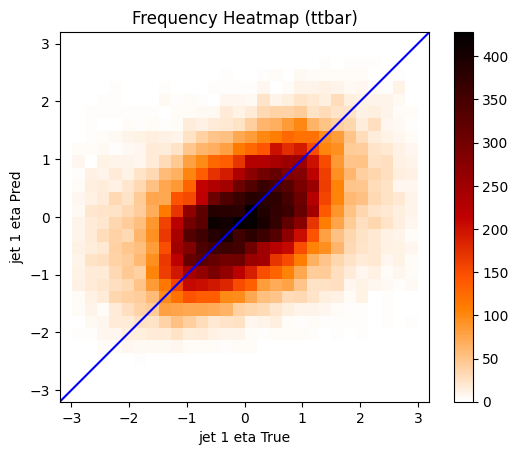

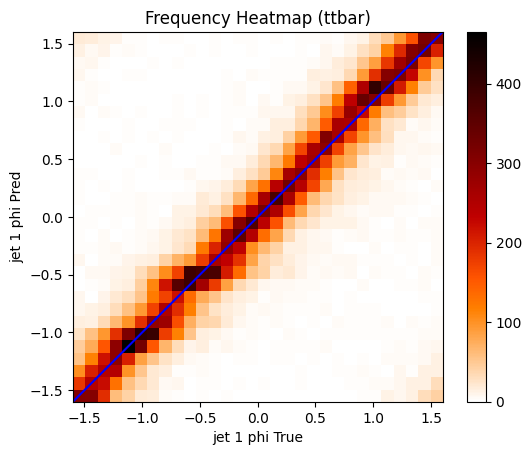

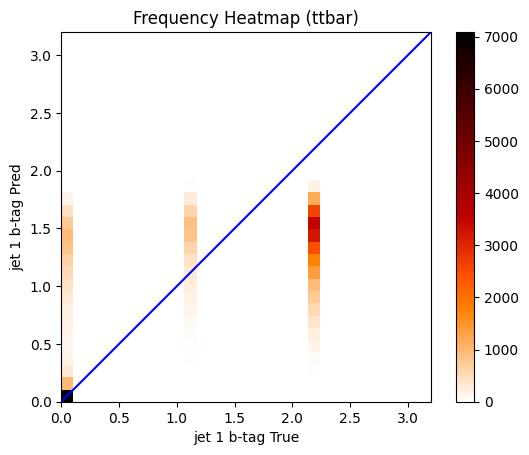

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


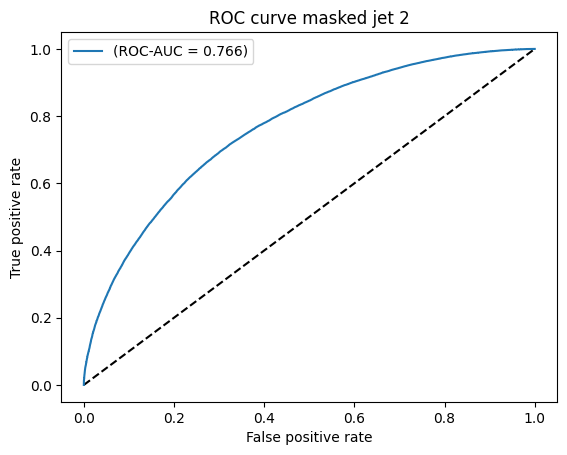

Classification Accuracy (masked  jet 2 ):  0.6971130288697113


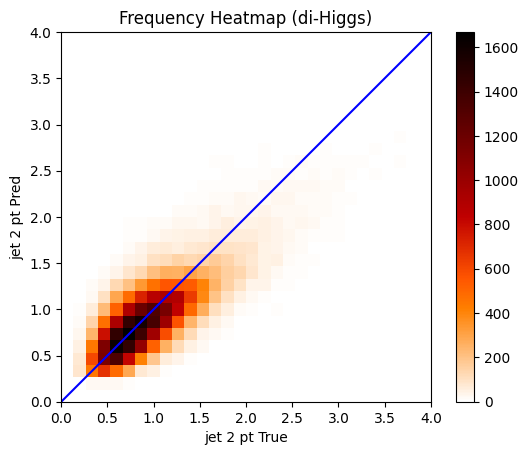

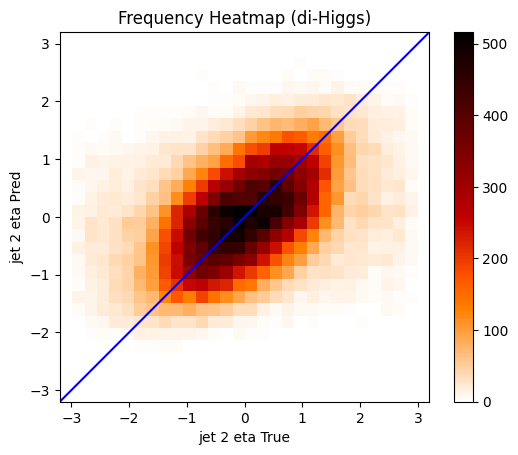

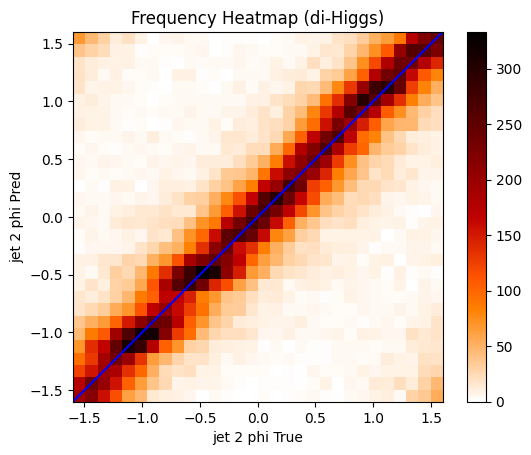

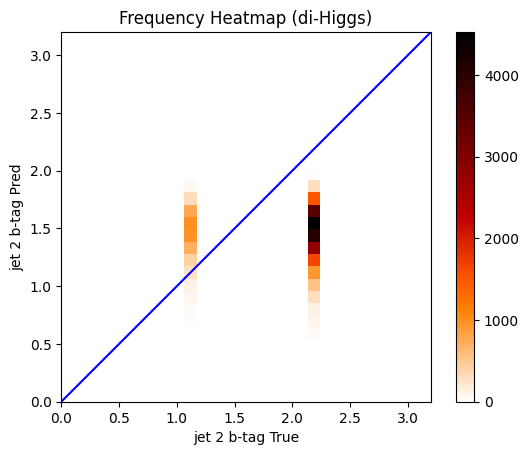

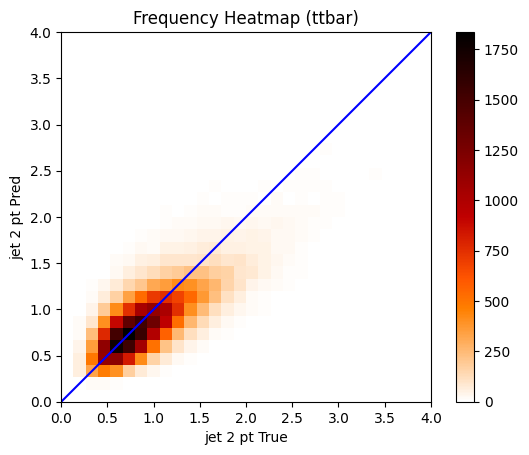

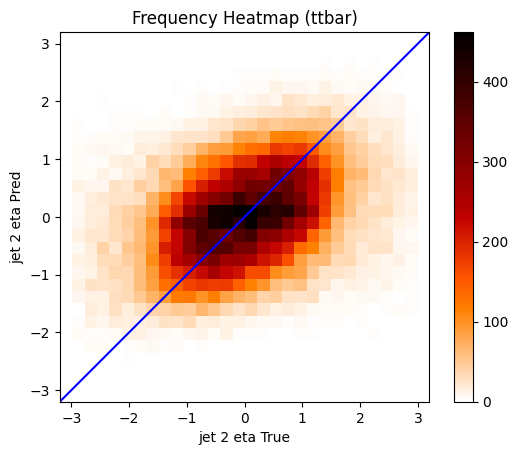

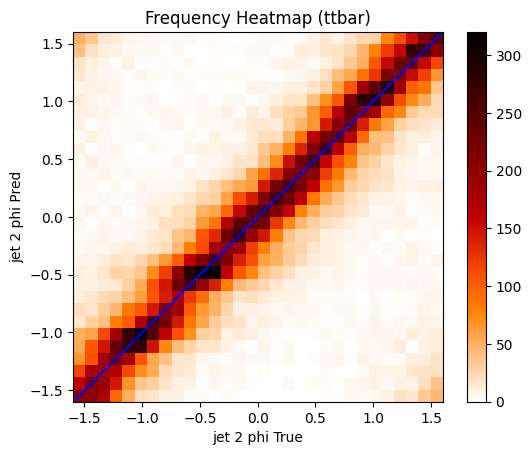

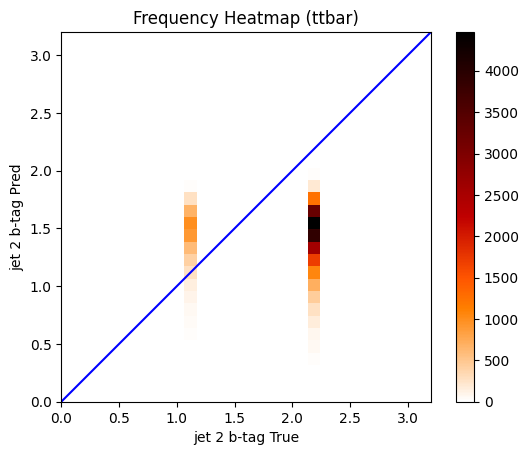

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


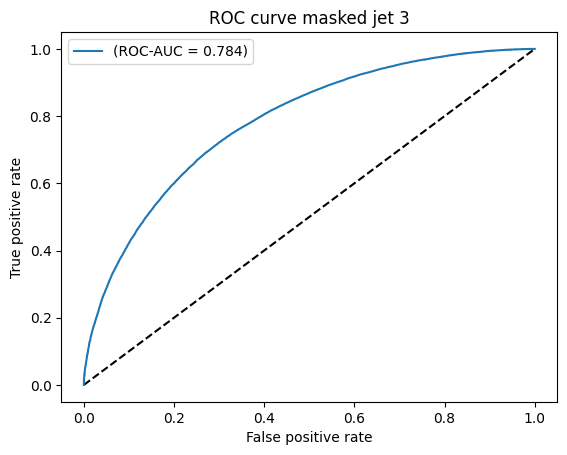

Classification Accuracy (masked  jet 3 ):  0.7119428805711943


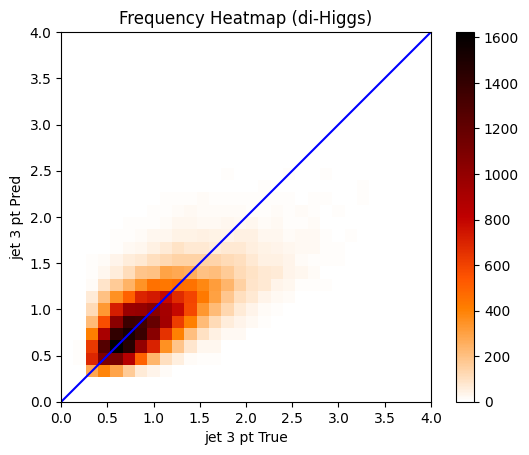

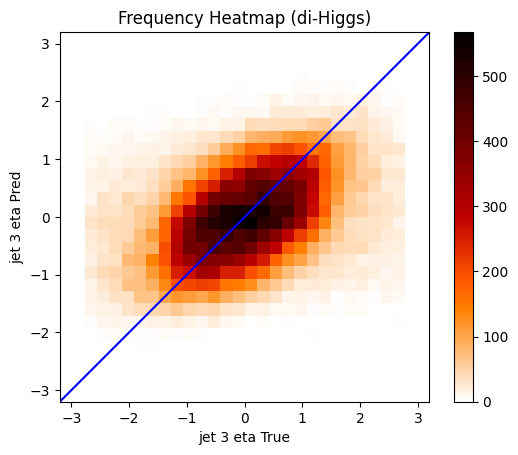

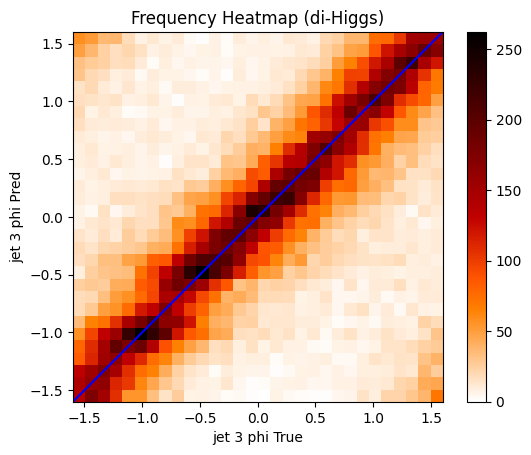

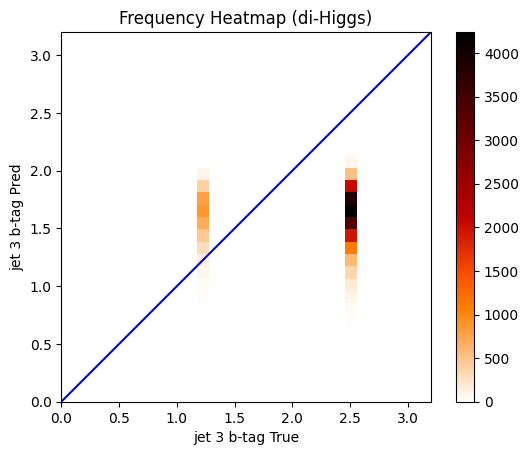

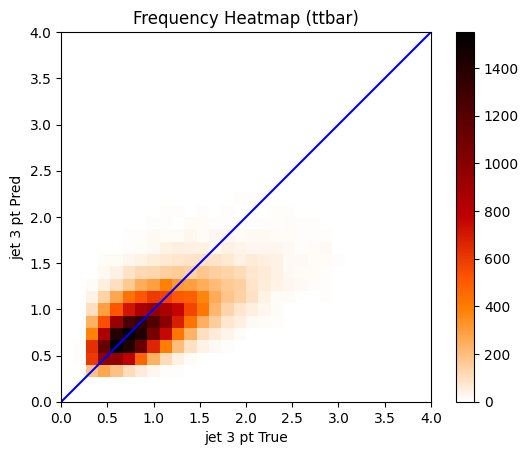

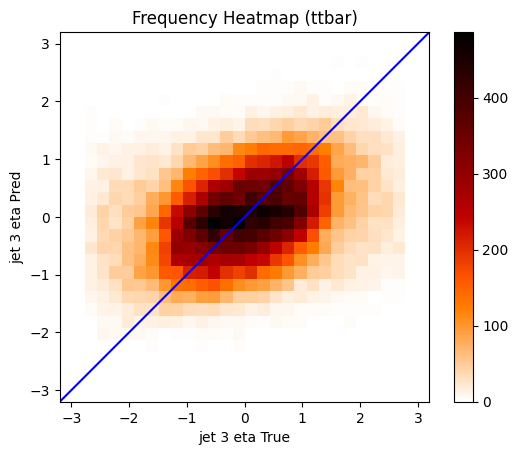

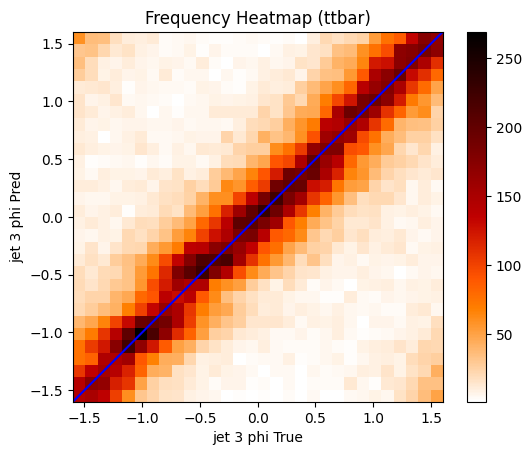

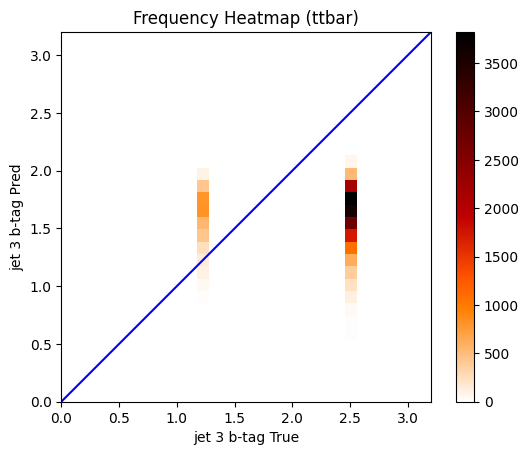

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


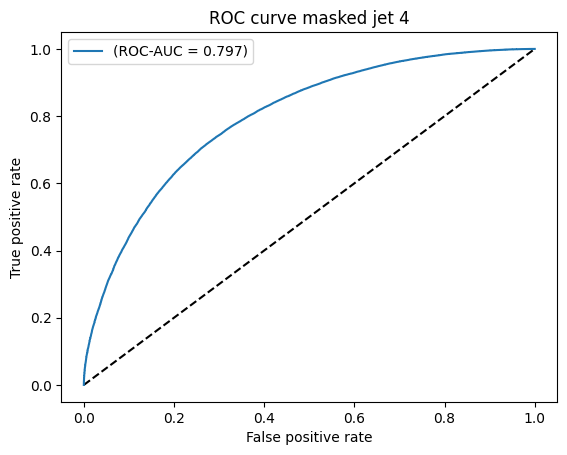

Classification Accuracy (masked  jet 4 ):  0.7237527624723753


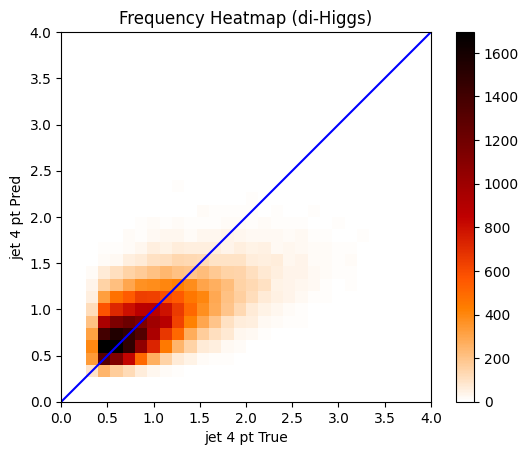

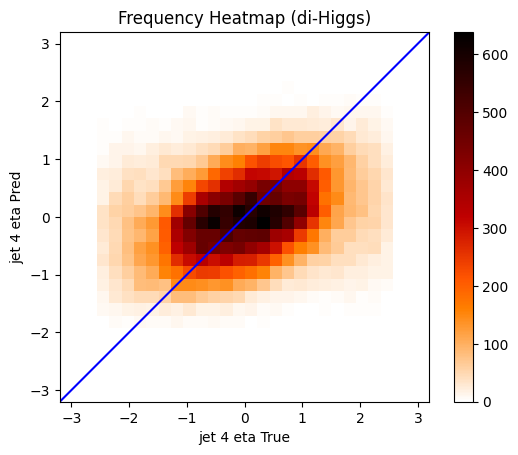

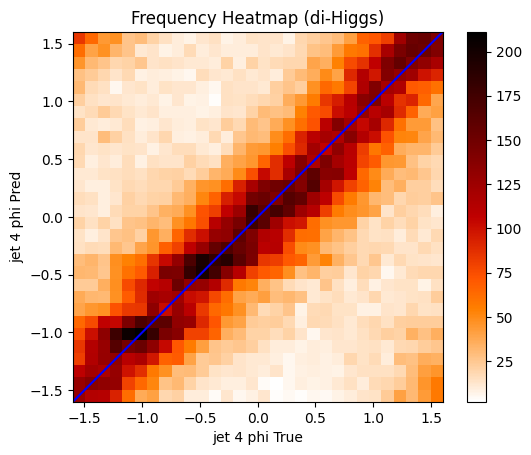

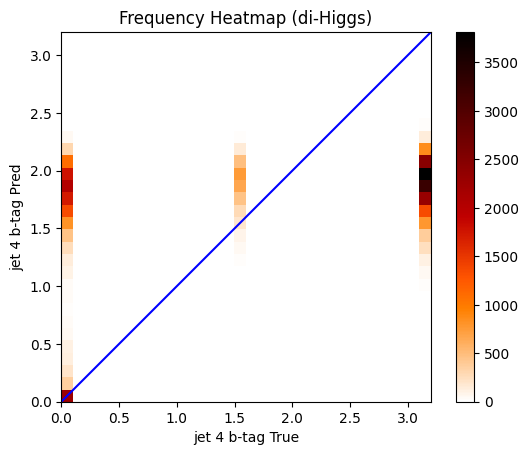

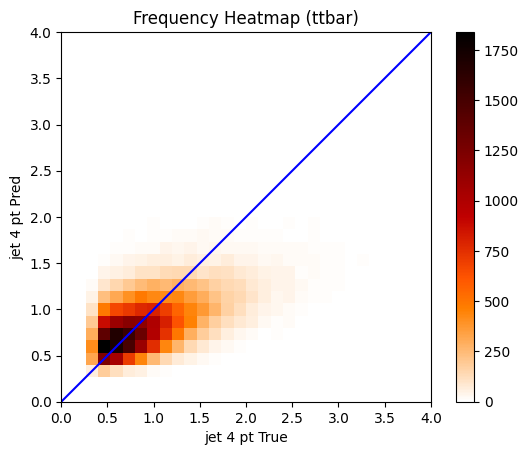

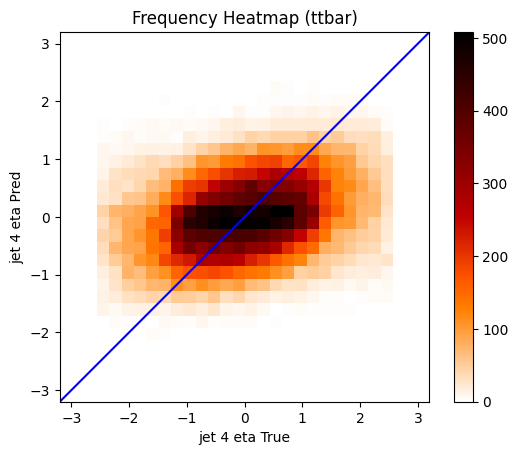

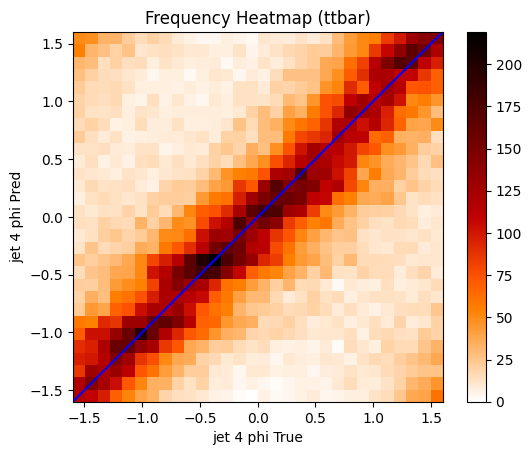

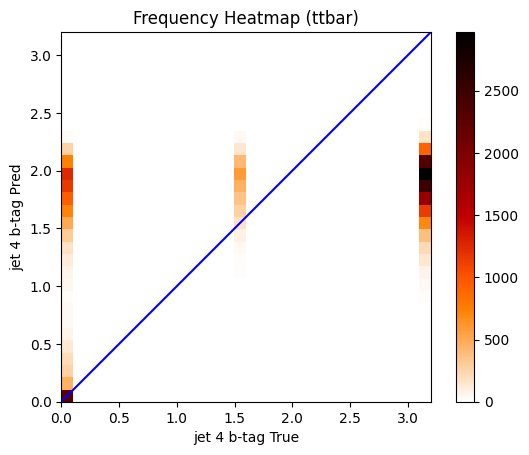

In [40]:
bin_class.load_state_dict(torch.load('./saved_models/uci_higgs/Classifier_partial_best_' + model_name))
test_and_plot.test(test_loader, config['test_batch_size'], X_test, labels_test, names, [tae, bin_class], device,
                   config['mask'], x_scaler, config['output_vars'], 'partial', model_name)

# Note: zero-padded values aren't part of the loss function in this demo